In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Convolution2D, ZeroPadding2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing 
from keras import regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:

from tensorflow.keras.applications import vgg19
# Init the VGG model
vgg_conv = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling='max')
vgg_conv.summary()

In [ ]:
# Freeze all the layers

for layer in vgg_conv.layers[:]:
  layer.trainable = False
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
  print(layer, layer.trainable)

In [ ]:
# Create the model
model = Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_regularizer=l1(0.001), bias_regularizer=l1(0)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu',kernel_regularizer=l1(0.001), bias_regularizer=l1(0)))
model.add(Dense(8, activation='softmax',kernel_regularizer=l1(0.001), bias_regularizer=l1(0)))
# Show a summary of the model. Check the number of trainable parameters
model.summary()


In [ ]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
traindf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/train.csv',dtype=str)


In [ ]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',validation_split=0.3)

In [ ]:
train_generator=training_datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/Colab Notebooks/dataset/train",
x_col="Image",
y_col="target",
has_ext=False,
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",

target_size=(224,224))


In [ ]:

validation_generator=training_datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/Colab Notebooks/dataset/train",
x_col="Image",
y_col="target",
has_ext=False,
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",

target_size=(224,224))

Found 109 validated image filenames belonging to 8 classes.


In [ ]:
opt=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
# Configure the model for training

model.compile( loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
 
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=150,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,callbacks=[reduce_learning_rate,checkpoint,early])
model.save('Identify_the_dance_form.h5')


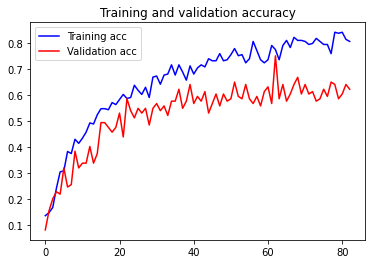

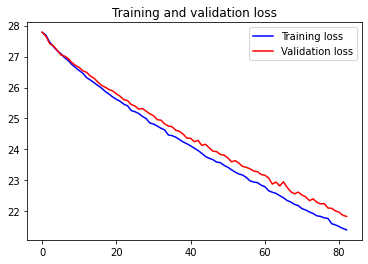

In [ ]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
# Run the function to illustrate accuracy and loss
visualize_results(history)

